# Neural Network for Predicting Pedestrians Velocity

In [1]:
# import all the required packages
import os
import datetime
import tensorboard
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import pytorch_lightning as pl

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

%load_ext autoreload
%autoreload 2
%matplotlib inline

## 1. Data Preparation

#### Path

In [2]:
root = os.getcwd()
vadere_dataset_path = os.path.join(root, "dataset", "vadere_generated")

#### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using the device",device)

Using the device cuda:0


### Data Preprocessing: 
Check codes: utils\vadereOutputLoader.py

#### The following codes load a trial dataset.

In [4]:
from utils.vadereOutputLoader import vadereOutputLoader

nameOfDataset = "trial_data.txt"
numOfNeighbours = 3
contain_sk = True
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

vadereRawdataLoader = vadereOutputLoader(vadere_dataset_path, vadere_dataset_path)
vadereRawdata, sk = vadereRawdataLoader.loadData(nameOfDataset, numOfNeighbours, need_processing=True, contain_sk=contain_sk, return_sk=True)

#### The following codes load the bottlenect datasets.

In [5]:
from utils.vadereOutputLoader import vadereOutputLoader

dataset_name_list = ["bottleneck_070.txt", "bottleneck_095.txt",
                     "bottleneck_120.txt", "bottleneck_180.txt"]
numOfNeighbours = 10
contain_sk = True
numOfCols = 4 + 2*numOfNeighbours - (not contain_sk)

vadereRawdataLoader = vadereOutputLoader(
    vadere_dataset_path, vadere_dataset_path)
vadereRawdata, sk = vadereRawdataLoader.mergeDataset(
    dataset_name_list, "merged_bottleneck.txt", numOfNeighbours, need_processing=True, contain_sk=contain_sk, return_sk=True)


In [6]:
vadereRawdata.shape

(17819, 22)

In [7]:
sk.shape

(17819,)

#### Customized Dataset class and Dataloaders: 
Check codes: utils\crowdDataset.py

In [8]:
from utils.crowdDataset import crowdDataset

total = len(vadereRawdata)
randidx = np.arange(total)
np.random.shuffle(randidx)

train_idx = np.arange(int(total*.75))
val_idx = np.arange(int(total*.75), total)

train = crowdDataset(vadereRawdata[train_idx], device)
val = crowdDataset(vadereRawdata[val_idx], device)
#test = crowdDataset(vadereRawdata[int(total*.8):], device)

batch_size = 32
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=False)
#testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)


## 2. Training Neural Network

In [9]:
%tensorboard --logdir lightning_logs

UsageError: Line magic function `%tensorboard` not found.


#### Define the network

In [26]:
from utils.network import FullyConnectedNet

hparams = {
    "numOfLayers": 1,
    "layerSize": [3],
    "learning_rate": 0.0001
}

model = FullyConnectedNet(hparams=hparams, input_size=vadereRawdata.shape[1]-1, output_size=1)

In [27]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

trainer = pl.Trainer(
    max_epochs=50,
    progress_bar_refresh_rate=25,
    gpus=1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=5)]
)

trainer.fit(model, train_dataloader=trainloader, val_dataloaders=valloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | model     | ModuleList | 93    
-----------------------------------------
93        Trainable params
0         Non-trainable params
93        Total params
0.000     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 558/558 [00:02<00:00, 259.99it/s, loss=0.313, v_num=16]


In [16]:
trainer.logged_metrics

{'epoch': tensor(9.),
 'val_loss': tensor(0.1101),
 'train_loss': tensor(0.1295, device='cuda:0')}

#### Output summary of the trained model: 

d:\GitHub\MLCMS-Final-Project\NN1_model_summary.txt exists, model summary will be attached to the end of this file.


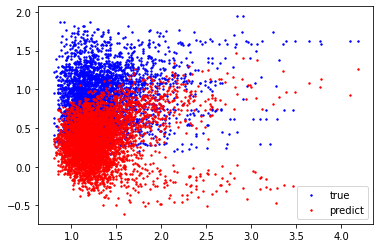

(4455,) (4455,) (4455,)
Plot saved as d:\GitHub\MLCMS-Final-Project\plots\1_4.png
Model prediction saved as d:\GitHub\MLCMS-Final-Project\model_prediction\1_4_prediction.txt


In [45]:
if contain_sk:
    summary_file_path = os.path.join(root, "NN1_model_summary.txt")
else:
    summary_file_path = os.path.join(root, "NN2_model_summary.txt")

vhat = model(torch.tensor(vadereRawdata[val_idx, 1:], dtype=torch.float32)).detach().numpy().reshape(-1)
v = torch.tensor(vadereRawdata[val_idx, 0], dtype=torch.float32).detach().numpy()

model.output_summary(v, vhat, sk[val_idx], trainer.logged_metrics, "B", "B", summary_file_path)